## Pip installs

In [6]:
!pip install -q scikit-learn-intelex

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.2/63.2 MB 11.4 MB/s eta 0:00:00


In [7]:
!pip install numpy usearch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 9.1 MB/s eta 0:00:00


In [1]:
!pip install -q fastKDE

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.4 MB/s eta 0:00:00


## Libraries

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from usearch.index import search, MetricKind
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter
import fastkde

## Creating FastKDE function and showing sampling

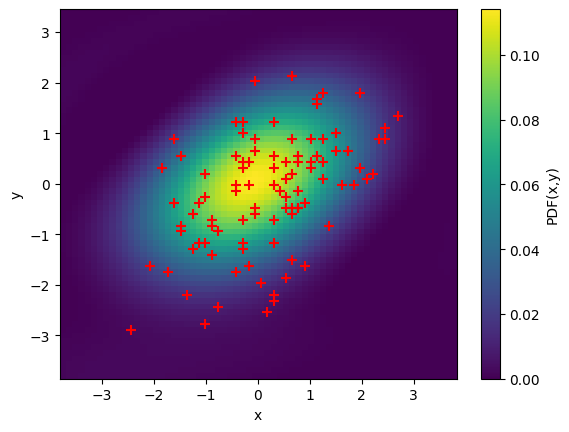

In [ ]:
def sample_and_plot_from_fastkde(x, y, n_samples):
    # Estimate the PDF using fastkde
    myPDF = fastkde.pdf(x_data, y_data, var_names=['x', 'y'])

    # Plot the PDF
    myPDF.plot()

    # Flatten the n-dimensional arrays
    flat_pdf = np.array(myPDF).flatten()

    # Generate and plot samples
    for _ in range(n_samples):
        # Generate a random index based on the flattened PDF
        ij = np.random.choice(np.arange(len(flat_pdf)), p=(flat_pdf / flat_pdf.sum()))

        # Calculate x and y indices
        x_index = np.floor(ij / len(myPDF.y)).astype(int)
        y_index = ij % len(myPDF.y)

        # Sample values from myPDF
        x_sample = float(np.array(myPDF.x[x_index]))
        y_sample = float(np.array(myPDF.y[y_index]))

        # Plot the sample on the PDF
        plt.scatter(x_sample, y_sample, marker='+', s=50, color='red')

    # Show the plot
    plt.show()

# Generate example data
N1 = np.random.normal(size=1000)
N2 = np.random.normal(scale=0.5, size=1000)
x_data = N1 + 1.5 * N2
y_data = N1 - N2

# Number of samples
n_samples = 100

# Call the function
sample_and_plot_from_fastkde(x_data, y_data, n_samples)


In [3]:
def sample_fastkde(X, y, n_samples, random_state=None, vector_shape=None):
    minority_features = X[y == 1]

    lb = minority_features.min(axis=0)
    ub = minority_features.max(axis=0)

    # Generate points between the lower bound (lb) and upper bound (ub)
    testpoints = np.random.uniform(low=lb, high=ub, size=(n_samples, 2))

    # Compute the PDF using FastKDE
    pdf = fastkde.pdf_at_points(minority_features[:, 0], minority_features[:, 1],
                                list_of_points=testpoints, num_points=2 ** 9 + 1)

    # Select points based on the PDF percentile
    fakes = testpoints[pdf > np.percentile(pdf, 70)]

    # Append the fake samples to the original dataset
    X_appended = np.row_stack([X, fakes])
    y_appended = np.concatenate([y, np.ones(len(fakes))])

    # If vector_shape is provided, reshape the output
    if vector_shape:
        X_appended = X_appended.reshape(vector_shape)

    return X_appended, y_appended

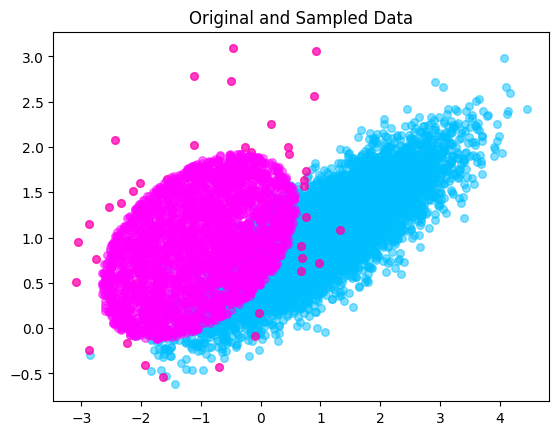

In [4]:
# Generate dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
                           n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

# Sample using FastKDE approximation
X_sampled, y_sampled = sample_fastkde(X, y, n_samples=10000, random_state=42)

# Visualize the original and sampled data
plt.scatter(X[y == 0, 0], X[y == 0, 1], color='DeepSkyBlue', s=30, alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='red', s=30, alpha=0.5)
plt.scatter(X_sampled[y_sampled == 1, 0], X_sampled[y_sampled == 1, 1], color='magenta', s=30, alpha=0.5)
plt.title('Original and Sampled Data')
plt.show()

## KNN Class Using USearch Library

In [5]:
def most_common(lst):
    unique, counts = np.unique(lst, return_counts=True)
    max_count = np.max(counts)
    most_common_labels = unique[counts == max_count]
    return most_common_labels[0] if len(most_common_labels) == 1 else most_common_labels[np.random.randint(len(most_common_labels))]

class KNeighborsClassifier:
    def __init__(self, k=5):
        self.k = k

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        neighbors = []
        for x in X_test:
            result = search(self.X_train, x, self.k, MetricKind.L2sq, exact=True)
            ind = np.array(result.to_list())[:,0].astype('int64')
            ind = np.sort(ind)
            d = result.distances
            distances_sorted = np.sqrt(d)[np.argsort(ind)]

            nearest_indices = np.argsort(distances_sorted)
            nearest_labels = self.y_train[nearest_indices]
            neighbors.append(nearest_labels)
        return list(map(most_common, neighbors))

    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        accuracy = np.sum(y_pred == y_test) / len(y_test)
        return accuracy

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.sum(y_pred == y) / len(y)

    def get_params(self, deep=True):
        return {'k': self.k}

    def set_params(self, **params):
        self.k = params['k']
        return self

## Creating Dataset and Sampling Data With SMOTE, ADASYN, and FastKDE

In [9]:
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
                           n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
oversample = SMOTE()
X_smote, y_smote = oversample.fit_resample(X, y)
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

adasyn = ADASYN(random_state=42)
X_adasyn, y_adasyn = adasyn.fit_resample(X, y)
X_train_adasyn, X_test_adasyn, y_train_adasyn, y_test_adasyn = train_test_split(X_adasyn, y_adasyn, test_size=0.2, random_state=42)


## Testing Data Sampling on KNN Class

In [11]:
knn = KNeighborsClassifier()

results = {}

In [13]:
# Cross-validation tuning for SMOTE
best_k_smote = None
best_accuracy_smote = 0
for k in range(1, 11):
    knn = KNeighborsClassifier(k=k)
    scores = cross_val_score(knn, X_train_smote, y_train_smote, cv=5, scoring='accuracy')
    if np.mean(scores) > best_accuracy_smote:
        best_accuracy_smote = np.mean(scores)
        best_k_smote = k
results['SMOTE'] = {'best_k': best_k_smote, 'best_accuracy': best_accuracy_smote}

In [14]:
# Cross-validation tuning for ADASYN
best_k_adasyn = None
best_accuracy_adasyn = 0
for k in range(1, 11):
    knn = KNeighborsClassifier(k=k)
    scores = cross_val_score(knn, X_train_adasyn, y_train_adasyn, cv=5, scoring='accuracy')
    if np.mean(scores) > best_accuracy_adasyn:
        best_accuracy_adasyn = np.mean(scores)
        best_k_adasyn = k
results['ADASYN'] = {'best_k': best_k_adasyn, 'best_accuracy': best_accuracy_adasyn}

In [12]:
# Cross-validation tuning for FastKDE
best_k_fastkde = None
best_accuracy_fastkde = 0
for k in range(1, 11):
    knn = KNeighborsClassifier(k=k)
    scores = cross_val_score(knn, X_sampled, y_sampled, cv=5, scoring='accuracy')
    if np.mean(scores) > best_accuracy_fastkde:
        best_accuracy_fastkde = np.mean(scores)
        best_k_fastkde = k
results['FastKDE'] = {'best_k': best_k_fastkde, 'best_accuracy': best_accuracy_fastkde}

In [15]:
for method, result in results.items():
    print(f"{method} - Best k: {result['best_k']}, Best accuracy: {result['best_accuracy']:.4f}")

FastKDE - Best k: 1, Best accuracy: 0.7615
SMOTE - Best k: 2, Best accuracy: 0.5064
ADASYN - Best k: 3, Best accuracy: 0.4998


# Capstone Project

## ASL Alphabet Recognition and Real-time Prediction using Neural Networks

### Reference to the Dataset

The dataset used for this project consists of images of the American Sign Language (ASL) alphabet, sourced from an extensive collection designed specifically for ASL recognition.

#### About the Dataset
The dataset is a curated collection of images depicting letters of the alphabet from the American Sign Language, organized into 29 distinct folders representing the various classes.

#### Content
- **Training Dataset**: The training dataset comprises 87,000 images, each with dimensions of 200x200 pixels. It encompasses 29 classes, with 26 classes corresponding to the letters A-Z and an additional 3 classes designated for SPACE, DELETE, and NOTHING. These specialized classes significantly enhance the model's performance in real-time applications and classification tasks.

- **Test Dataset**: The test dataset consists of a modest set of 29 images. This limited size is intentional, aiming to promote the evaluation of the model's performance using real-world test images, thereby ensuring its robustness and applicability in practical scenarios. Therefore, the dataset will be further tested manually to validate the accuracy and reliability of the model's predictions.

https://www.kaggle.com/datasets/grassknoted/asl-alphabet/data


### Abstract
This capstone project aims to develop and evaluate multiple neural network architectures for accurate prediction of the American Sign Language (ASL) alphabet. The project leverages a comprehensive dataset of ASL alphabet images to train, validate, and test the neural networks. Upon choosing a successful model, the trained neural network will be deployed to predict real-time sign language gestures captured through a camera.

### Main Goal
The primary objective of this capstone project is to design, train, and deploy neural networks capable of accurately recognizing and predicting the ASL alphabet. Furthermore, the project will extend the application of the trained model to real-time prediction, enabling it to interpret and predict sign language gestures in a live video feed from a camera.
